# Imports

In [ ]:
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import math
from PIL import Image
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
print(torch.cuda.is_available())
print(torch.__version__)
import random
import csv
import string
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
#data
from google.colab import drive
import zipfile
import os


True
2.6.0+cu124


# Utils

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)  # [B, C, H, W]
    targets = torch.cat(labels)
    label_lengths = torch.tensor([len(l) for l in labels], dtype=torch.long)  # [B]
    input_lengths = torch.full((len(images),), 18, dtype=torch.long)  # [B]

    return images, targets, input_lengths, label_lengths


In [ ]:
def ctc_decode(pred_indices, idx_to_char, blank_idx=0):
    decoded = []
    prev = None
    for i in pred_indices:
        if i != prev and i != blank_idx:
            decoded.append(idx_to_char[i])
        prev = i
    return ''.join(decoded)

# Data

In [ ]:
drive.mount('/content/drive')

# 2. Percorso del tuo ZIP (modifica il path se diverso)
zip_path = "/content/drive/MyDrive/Dataset_CV/RECOGNITION/UC3-LM_recognition.zip"

# 3. Estrazione nella cartella corrente
extract_dir = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
chars = list(string.ascii_uppercase) + list(string.digits)

# Il carattere '-' è riservato come blank per CTC (indice 0)
idx_to_char = ['-'] + sorted(chars)
char_to_idx = {char: idx for idx, char in enumerate(idx_to_char)}
vocab = list(char_to_idx.keys())
num_classes = len(idx_to_char)  # da usare per definire il decoder


In [ ]:
class LicensePlateDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None, charset=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.charset = charset or list("ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789")
        self.char_to_idx = {c: i+1 for i, c in enumerate(self.charset)}  # 0 = blank

        self.image_files = sorted([
            f for f in os.listdir(images_dir)
            if f.endswith(('.jpg', '.png')) and os.path.isfile(os.path.join(labels_dir, f.replace('.jpg', '.txt')))
        ])

    def __len__(self):
        return len(self.image_files)

    def encode_label(self, text):
        return torch.tensor([self.char_to_idx[c] for c in text if c in self.char_to_idx], dtype=torch.long)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        label_path = os.path.join(self.labels_dir, img_name.replace('.jpg', '.txt'))

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        with open(label_path, 'r') as f:
            label_text = f.read().strip()

        label_tensor = self.encode_label(label_text)
        return image, label_tensor


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((48, 144)),

    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,

    ),

    transforms.RandomAffine(
        degrees=2,
        translate=(0.02, 0.02),
        scale=(0.9, 1.1)
    ),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# === VALIDATION/TEST TRANSFORM ===
val_transform = transforms.Compose([
    transforms.Resize((48, 144)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((48, 144)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [ ]:
train_dataset = LicensePlateDataset(
    images_dir='/content/filtered_OCR_clean/images/train',
    labels_dir='/content/filtered_OCR_clean/labels/train',
    transform=train_transform
)

val_dataset = LicensePlateDataset(
    images_dir='/content/filtered_OCR_clean/images/val',
    labels_dir='/content/filtered_OCR_clean/labels/val',
    transform=val_transform
)
test_dataset = LicensePlateDataset(
    images_dir="/content/filtered_OCR_clean/images/test",
    labels_dir="/content/filtered_OCR_clean/labels/test",
    transform=test_transform,
    charset=list("ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789")
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)



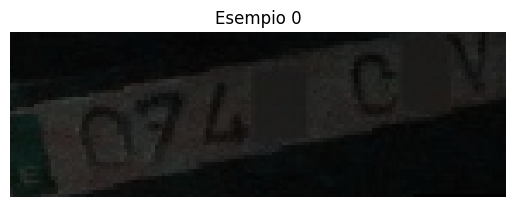

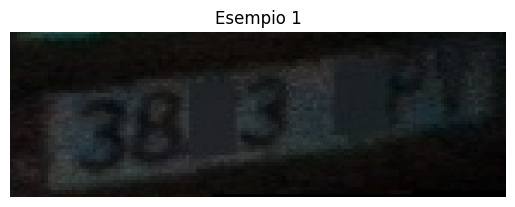

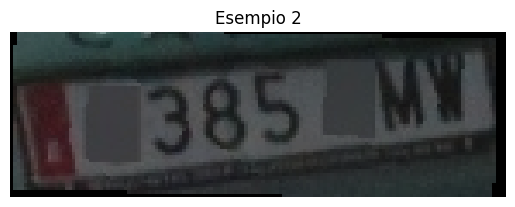

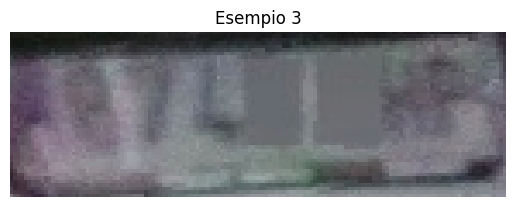

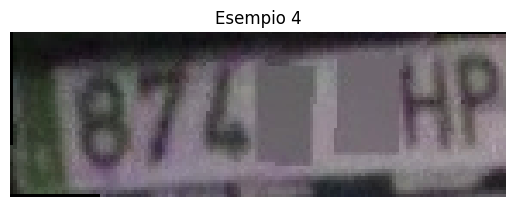

In [ ]:
for i in range(5):
    img, _ = train_dataset[i]
    img = img.permute(1, 2, 0) * 0.5 + 0.5
    plt.imshow(img.numpy())
    plt.title(f"Esempio {i}")
    plt.axis('off')
    plt.show()

# Network

## IGFE

### Focus structure Module

Obiettivo: diminuire la dimensione spaziale dell'immagine senza perdita di informazione. \\

è il primo step di IGFE. \\

prende in input un tensore (3,48,144) (canale,altezza,larghezza) e deve fare poi: \\
1) slicing dell'immagine: si prendono pixel a intervalli alternati per ottenere 4 feature maps da 3 canali ciascuno -> (3, 24, 72) \\
2) concatenazione lungo il canale (torch.cat): si concatenano tutte queste mappe e si ottengono feature map di dimensione ->  (12, 24, 72)  \\
3) convoluzione (Conv2d): il paper non specifica i parametri usati. Yolov5 usa: Conv2d(in_channels=12, out_channels=32, kernel_size=3, stride=1, padding=1)


In [ ]:
class FocusStructure(nn.Module):
    def __init__(self, in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1):
        super(FocusStructure, self).__init__()
        self.conv = nn.Conv2d(in_channels * 4, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        # slicing
        x1 = x[..., ::2, ::2]
        x2 = x[..., ::2, 1::2]
        x3 = x[..., 1::2, ::2]
        x4 = x[..., 1::2, 1::2]
        #concatenation
        x = torch.cat([x1, x2, x3, x4], dim=1)
        return self.conv(x)

### RESBLOCK

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class RESBLOCK(nn.Module):
    def __init__(self, channels):
        super(RESBLOCK, self).__init__()
        self.cnn1 = CNNBlock(channels, channels)
        self.cnn2 = CNNBlock(channels, channels)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.cnn2(out)
        return out + x  # residual connection

### ConvDownSampling

In [ ]:
class ConvDownSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvDownSampling, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

### Feature extractor

In [ ]:
class IGFE(nn.Module):
    def __init__(self):
        super().__init__()
        self.focus = FocusStructure()            # [3, 48, 144] → [32, 24, 72]
        self.res1 = RESBLOCK(32)
        self.res2 = RESBLOCK(32)
        self.down1 = ConvDownSampling(32, 256)   # [12, 24, 72] → [256, 12, 36]
        self.res3 = RESBLOCK(256)
        self.res4 = RESBLOCK(256)
        self.down2 = ConvDownSampling(256, 512)  # [256, 12, 36] → [512, 6, 18]

    def forward(self, x):
        x = self.focus(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.down1(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.down2(x)
        return x  # Final Output: [B, 512, 6, 18]

## Encoder

Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, height, width):
        super(PositionalEncoding, self).__init__()
        self.height = height
        self.width = width

        if d_model % 4 != 0:
            raise ValueError("d_model must be divisible by 4 for 2D positional encoding")

        pe = torch.zeros(d_model, height, width)
        d_model_half = d_model // 2
        div_term = torch.exp(torch.arange(0, d_model_half, 2).float() * (-math.log(10000.0) / d_model_half))

        pos_w = torch.arange(0, width).unsqueeze(1)
        pos_h = torch.arange(0, height).unsqueeze(1)

        pe[0:d_model_half:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model_half:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model_half::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model_half + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)

        self.register_buffer('pe', pe.unsqueeze(0))  # [1, d_model, H, W]

    def forward(self, x):
        return x + self.pe[:, :, :x.size(2), :x.size(3)]

In [ ]:
class EncoderUnit(nn.Module):
    def __init__(self, d_model=512, d_mha=1024, n_heads=8, height=6, width=18):
        super(EncoderUnit, self).__init__()
        self.height = height
        self.width = width
        self.d_mha = d_mha

        self.conv1 = nn.Conv2d(d_model, d_mha, kernel_size=1)
        self.mha = nn.MultiheadAttention(d_mha, n_heads, batch_first=True)
        self.conv2 = nn.Conv2d(d_mha, d_model, kernel_size=1)
        self.norm = nn.LayerNorm(d_model)  # **LayerNorm **

    def forward(self, x):
        B, C, H, W = x.shape
        # Conv1 → [B, 1024, 6, 18]
        x1 = self.conv1(x)

        # Flatten for MHA → [B, 108, 1024]
        x1_seq = x1.view(B, self.d_mha, H * W).permute(0, 2, 1)

        # Multi-Head Attention
        attn_out, _ = self.mha(x1_seq, x1_seq, x1_seq)  # [B, 108, 1024]

        # Reshape a feature map and CNN BLOCK 2
        attn_out = attn_out.permute(0, 2, 1).view(B, self.d_mha, H, W)
        x2 = self.conv2(attn_out)  # [B, 512, 6, 18]

        # Residual + LayerNorm **(token-wise)**
        # Flatten of x e x2 → [B, 108, 512]
        x2_seq = x2.view(B, C, H * W).permute(0, 2, 1)
        x_res_seq = x.view(B, C, H * W).permute(0, 2, 1)

        norm_out = self.norm(x2_seq + x_res_seq)

        # return to the previous dimensions [B, 512, 6, 18]
        out = norm_out.permute(0, 2, 1).view(B, C, H, W)
        return out

class Encoder(nn.Module):
    def __init__(self, d_model=512, d_mha=1024, n_heads=8, num_units=3, height=6, width=18):
        super(Encoder, self).__init__()
        self.pe2d = PositionalEncoding(d_model, height, width)
        self.encoder_units = nn.ModuleList([
            EncoderUnit(d_model=d_model, d_mha=d_mha, n_heads=n_heads, height=height, width=width)
            for _ in range(num_units)
        ])

    def forward(self, x):
        # x: [B, 512, 6, 18]
        x = self.pe2d(x)
        for unit in self.encoder_units:
            x = unit(x)
        return x  # [B, 512, 6, 18]


## Decoder

In [ ]:
class PositionalEncoding1D(nn.Module):
    def __init__(self, d_model, max_len=18):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # [1, max_len, d_model]

    def forward(self, x):  # x: [B, T, D]
        if x.size(1) > self.pe.size(1):
            raise ValueError(f"Sequence length {x.size(1)} exceeds max_len={self.pe.size(1)} in PositionalEncoding1D.")
        return x + self.pe[:, :x.size(1)].to(x.device)

# === Masked Self-Attention ===
class MaskedMultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        B, T, _ = x.shape
        mask = torch.triu(torch.ones(T, T) * float('-inf'), diagonal=1).to(x.device)
        attn_output, _ = self.attn(x, x, x, attn_mask=mask)
        return self.norm(x + attn_output)


# === Cross-Attention ===
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x, context):
        attn_output, _ = self.attn(x, context, context)
        return self.norm(x + attn_output)


# === Feed Forward Network ===
class FeedForwardNetwork(nn.Module):
    def __init__(self, embed_dim, dropout=0.1):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, embed_dim)
        )
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        return self.norm(x + self.ff(x))


# === Decoder Layer: masked self-attn → cross-attn → FFN ===
class DecoderLayer(nn.Module):
    def __init__(self, embed_dim=512, num_heads=8):
        super().__init__()
        self.self_attn = MaskedMultiHeadSelfAttention(embed_dim, num_heads)
        self.cross_attn = CrossAttention(embed_dim, num_heads)
        self.ffn = FeedForwardNetwork(embed_dim)

    def forward(self, x, encoder_out):
        x = self.self_attn(x)
        x = self.cross_attn(x, encoder_out)
        x = self.ffn(x)
        return x


# CNN BLOCK3 (2x1 kernel, stride=(3,1), padding=1)
class CNNBlock3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(512, 512, kernel_size=(2, 1), stride=(3, 1), padding=(1,0))
        self.norm = nn.BatchNorm2d(512)
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.act(self.norm(self.conv(x)))  # [B, 512, 3, 18] → approx

# CNN BLOCK4 (1x1 kernel, stride=(3,1), padding=(0,1))
class CNNBlock4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(512, 512, kernel_size=1, stride=(3, 1), padding=(0, 0))
        self.norm = nn.BatchNorm2d(512)
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.act(self.norm(self.conv(x)))  # [B, 512, 1, 18]



# === Final Parallel Decoder (CTC) ===
class ParallelTransformerDecoder(nn.Module):
    def __init__(self, num_classes, embed_dim=512, num_heads=8, num_layers=3, max_seq_len=18):
        super().__init__()
        self.block3 = CNNBlock3()
        self.block4 = CNNBlock4()
        self.pos_encoder = PositionalEncoding1D(embed_dim, max_len=max_seq_len)

        self.layers = nn.ModuleList([
            DecoderLayer(embed_dim, num_heads) for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(embed_dim, num_classes)

    def forward(self, encoder_out):  # encoder_out: [B, 512, 6, 18]
        x = self.block3(encoder_out)
        x = self.block4(x)
        x = x.squeeze(2).permute(0, 2, 1)
        x = self.pos_encoder(x)

        for i, layer in enumerate(self.layers):
            x = layer(x, x)
        logits = self.output_layer(x)
        return logits




# Train (Fine-tuning with checkpoints)

In [ ]:

class LicensePlateRecognizer(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.igfe = IGFE()
        self.encoder = Encoder(
            d_model=512, d_mha=1024, n_heads=8, num_units=3, height=6, width=18
        )
        self.decoder = ParallelTransformerDecoder(
            num_classes=vocab_size,
            embed_dim=512,
            num_heads=8,
            num_layers=3,
            max_seq_len=18
        )

    def forward(self, image):
        features = self.igfe(image)
        encoded = self.encoder(features)
        logits = self.decoder(encoded)
        return logits


In [ ]:


# === CONFIG ===
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_dir = "/content/drive/MyDrive/Computer_vision/checkpoints_PDLPR_UC3M-LP"
os.makedirs(checkpoint_dir, exist_ok=True)

last_ckpt_path = os.path.join(checkpoint_dir, "last.pth")
best_ckpt_path = os.path.join(checkpoint_dir, "best.pth")
pretrained_path = "/content/drive/MyDrive/Computer_vision/pdlpr_weights_ccpd2019/pdlpr_ccpd2019.pth"

# === MODEL ===
model = LicensePlateRecognizer(vocab_size=len(char_to_idx)).to(device)


criterion = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
optimizer = Adam(model.parameters(), lr=2e-4, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6, verbose=True)

if os.path.exists(last_ckpt_path):
    checkpoint = torch.load(last_ckpt_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict'] is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))
    print(f" Resumed from checkpoint (epoch {start_epoch})")

else:

    checkpoint = torch.load(pretrained_path, map_location=device)
    state_dict = checkpoint['model_state_dict']
    filtered_dict = {k: v for k, v in state_dict.items() if not k.startswith('decoder.output_layer')}
    model.load_state_dict(filtered_dict, strict=False)

    start_epoch = 0
    best_val_loss = float('inf')
    print(" Loaded pre-trained model")


def train_finetune(model, train_loader, val_loader, epochs, device, optimizer, criterion, seed=42, scheduler=None):
    set_seed(seed)
    global best_val_loss
    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"[FT] Epoch {epoch+1}/{epochs}")

        for images, labels, input_lengths, label_lengths in pbar:
            images = images.to(device)
            labels = labels.to(device)
            input_lengths = input_lengths.to(device)
            label_lengths = label_lengths.to(device)

            outputs = model(images)  # [B, T, C]
            log_probs = torch.nn.functional.log_softmax(outputs, dim=-1).permute(1, 0, 2)  # [T, B, C]

            loss = criterion(log_probs, labels, input_lengths, label_lengths)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(train_loss=total_loss / (pbar.n + 1), lr=optimizer.param_groups[0]['lr'])

        val_loss = evaluate_finetune(model, val_loader, criterion, device)
        print(f"\n[FT] Epoch {epoch+1} - Val Loss: {val_loss:.4f}")

        if scheduler:
            scheduler.step(val_loss)


        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'best_val_loss': best_val_loss
        }, last_ckpt_path)


        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_ckpt_path)
            print(f" New best model saved (Val Loss: {val_loss:.4f})")

def evaluate_finetune(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, labels, input_lengths, label_lengths in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            input_lengths = input_lengths.to(device)
            label_lengths = label_lengths.to(device)

            outputs = model(images)
            log_probs = torch.nn.functional.log_softmax(outputs, dim=-1).permute(1, 0, 2)
            loss = criterion(log_probs, labels, input_lengths, label_lengths)
            total_loss += loss.item()

    return total_loss / len(val_loader)

train_finetune(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    seed=42
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


 Loaded pre-trained model


[FT] Epoch 1/20: 100%|██████████| 64/64 [00:13<00:00,  4.85it/s, lr=0.0002, train_loss=3.41]



[FT] Epoch 1 - Val Loss: 2.7217
 New best model saved (Val Loss: 2.7217)


[FT] Epoch 2/20: 100%|██████████| 64/64 [00:13<00:00,  4.80it/s, lr=0.0002, train_loss=1.99]



[FT] Epoch 2 - Val Loss: 1.4916
 New best model saved (Val Loss: 1.4916)


[FT] Epoch 3/20: 100%|██████████| 64/64 [00:14<00:00,  4.51it/s, lr=0.0002, train_loss=0.965]



[FT] Epoch 3 - Val Loss: 0.5436
 New best model saved (Val Loss: 0.5436)


[FT] Epoch 4/20: 100%|██████████| 64/64 [00:13<00:00,  4.67it/s, lr=0.0002, train_loss=0.433]



[FT] Epoch 4 - Val Loss: 0.3887
 New best model saved (Val Loss: 0.3887)


[FT] Epoch 5/20: 100%|██████████| 64/64 [00:13<00:00,  4.78it/s, lr=0.0002, train_loss=0.467]



[FT] Epoch 5 - Val Loss: 0.2134
 New best model saved (Val Loss: 0.2134)


[FT] Epoch 6/20: 100%|██████████| 64/64 [00:13<00:00,  4.70it/s, lr=0.0002, train_loss=0.193]



[FT] Epoch 6 - Val Loss: 0.1508
 New best model saved (Val Loss: 0.1508)


[FT] Epoch 7/20: 100%|██████████| 64/64 [00:13<00:00,  4.59it/s, lr=0.0002, train_loss=0.181]



[FT] Epoch 7 - Val Loss: 0.1300
 New best model saved (Val Loss: 0.1300)


[FT] Epoch 8/20: 100%|██████████| 64/64 [00:13<00:00,  4.61it/s, lr=0.0002, train_loss=0.112]



[FT] Epoch 8 - Val Loss: 0.1293
 New best model saved (Val Loss: 0.1293)


[FT] Epoch 9/20: 100%|██████████| 64/64 [00:13<00:00,  4.74it/s, lr=0.0002, train_loss=0.101]



[FT] Epoch 9 - Val Loss: 0.1025
 New best model saved (Val Loss: 0.1025)


[FT] Epoch 10/20: 100%|██████████| 64/64 [00:13<00:00,  4.76it/s, lr=0.0002, train_loss=0.0686]



[FT] Epoch 10 - Val Loss: 0.1111


[FT] Epoch 11/20: 100%|██████████| 64/64 [00:13<00:00,  4.82it/s, lr=0.0002, train_loss=0.111]



[FT] Epoch 11 - Val Loss: 0.1134


[FT] Epoch 12/20: 100%|██████████| 64/64 [00:13<00:00,  4.84it/s, lr=0.0002, train_loss=0.0749]



[FT] Epoch 12 - Val Loss: 0.1100


[FT] Epoch 13/20: 100%|██████████| 64/64 [00:13<00:00,  4.72it/s, lr=0.0002, train_loss=0.0784]



[FT] Epoch 13 - Val Loss: 0.1427


[FT] Epoch 14/20: 100%|██████████| 64/64 [00:13<00:00,  4.76it/s, lr=0.0001, train_loss=0.11]



[FT] Epoch 14 - Val Loss: 0.0898
 New best model saved (Val Loss: 0.0898)


[FT] Epoch 15/20: 100%|██████████| 64/64 [00:14<00:00,  4.57it/s, lr=0.0001, train_loss=0.0369]



[FT] Epoch 15 - Val Loss: 0.0901


[FT] Epoch 16/20: 100%|██████████| 64/64 [00:14<00:00,  4.51it/s, lr=0.0001, train_loss=0.0328]



[FT] Epoch 16 - Val Loss: 0.0997


[FT] Epoch 17/20: 100%|██████████| 64/64 [00:13<00:00,  4.79it/s, lr=0.0001, train_loss=0.0267]



[FT] Epoch 17 - Val Loss: 0.0838
 New best model saved (Val Loss: 0.0838)


[FT] Epoch 18/20: 100%|██████████| 64/64 [00:13<00:00,  4.63it/s, lr=0.0001, train_loss=0.025]



[FT] Epoch 18 - Val Loss: 0.0754
 New best model saved (Val Loss: 0.0754)


[FT] Epoch 19/20: 100%|██████████| 64/64 [00:13<00:00,  4.73it/s, lr=0.0001, train_loss=0.0258]



[FT] Epoch 19 - Val Loss: 0.0706
 New best model saved (Val Loss: 0.0706)


[FT] Epoch 20/20: 100%|██████████| 64/64 [00:13<00:00,  4.69it/s, lr=0.0001, train_loss=0.0241]



[FT] Epoch 20 - Val Loss: 0.0721


# Test

In [ ]:
import torch
from tqdm import tqdm
import csv
import os

# === CONFIG ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = "/content/drive/MyDrive/Computer_vision/pdlpr_finetune_weights_uc3m-lp/pdlpr_uc3m-lp.pth"
blank_idx = 0  # indice del token blank (di solito 0)




# === RICOSTRUZIONE MODELLO ===
model = LicensePlateRecognizer(vocab_size=len(char_to_idx))
checkpoint = torch.load(checkpoint_path, map_location=device)


try:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded best model .")
except KeyError:
    model.load_state_dict(checkpoint)
    print(" Loaded best model.")

model.to(device)
model.eval()

# === FUNZIONE DI TEST ===
def test_model_ctc(model, test_loader, idx_to_char, blank_idx=0, device="cuda", save_csv=False, csv_path="ctc_predictions.csv"):
    model.to(device)
    model.eval()

    correct_full = 0
    correct_char = 0
    total_char = 0
    total_samples = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels, input_lengths, label_lengths in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)                        # [B, T, V]
            log_probs = torch.nn.functional.log_softmax(logits, dim=-1)  # [B, T, V]
            log_probs = log_probs.permute(1, 0, 2)        # [T, B, V]

            pred_indices = torch.argmax(log_probs, dim=-1).permute(1, 0)  # [B, T]

            for i in range(images.size(0)):
                pred_str = ctc_decode(pred_indices[i].tolist(), idx_to_char, blank_idx)

                start = sum(label_lengths[:i]).item() if i > 0 else 0
                end = start + label_lengths[i].item()
                label_seq = labels[start:end]
                true_str = ''.join([idx_to_char[idx.item()] for idx in label_seq if idx.item() != blank_idx])

                all_preds.append(pred_str)
                all_targets.append(true_str)

                if pred_str == true_str:
                    correct_full += 1
                correct_char += sum(p == t for p, t in zip(pred_str, true_str))
                total_char += max(len(pred_str), len(true_str))
                total_samples += 1

    seq_acc = correct_full / total_samples * 100
    char_acc = correct_char / total_char * 100
    print(f"\n Sequence Accuracy {seq_acc:.2f}%")
    print(f" Character Accuracy: {char_acc:.2f}%")

    if save_csv:
        with open(csv_path, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(["Ground Truth", "Prediction"])
            for gt, pred in zip(all_targets, all_preds):
                writer.writerow([gt, pred])
        print(f" Saved Predictions inn {csv_path}")


test_model_ctc(
    model=model,
    test_loader=test_loader,
    idx_to_char=idx_to_char,
    blank_idx=blank_idx,
    device=device,
    save_csv=False,
    csv_path="ctc_predictions.csv"
)


 Loaded best model.


100%|██████████| 5/5 [00:00<00:00, 11.43it/s]


 Sequence Accuracy 93.12%
 Character Accuracy: 97.88%
